Clustering scRNA-seq data is dangerous because it can turn into a 'time sink'. PySCN has some functions that might help you to more efficiently identify stable and meaning clusters in your scRNA-seq data. This tutorial shows you how to use these functions:

- `cluster_alot`: cluster adata across specified parameter values
- `clustering_quality_vs_nn_summary`: computes practical metrics of clustering quality
- `cluster_subcluster`: runs complete clustering procedure on specified sub-set of cells

In this tutorial, we shoul you how to use these functions to cluster the PBMC data below  

####  Data

- 10k PBMCs from a Healthy Donor (v3 chemistry) Single Cell Gene Expression Dataset by Cell Ranger 3.0.0
- From 10X Genomics [click here to download the processed data in h5ad](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/notebook_data/adPBMC_ref_040623.h5ad)

### Setting up

Import requisite packages

In [34]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import pySingleCellNet as cn
import marsilea as ma
import marsilea.plotter as mp

Load the data

In [35]:
adRef = sc.read_h5ad("../../data/adPBMC_ref_040623.h5ad")
adRef.shape

(10309, 20104)

Filter genes

In [36]:
min_cells = 50
adata = adRef.copy()
sc.pp.filter_genes(adata, min_cells = min_cells)
adata.shape

(10309, 13503)

Normalize counts

In [37]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

Identify highly variable genes and perform principle component analysis.

In [38]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='cell_ranger')
sc.tl.pca(adata, mask_var='highly_variable')

### Sir Cluster-Alot

The snippet below runs a typical clustering procedure. However, instead of running it just once, `cluster_alot` runs it once for each combination of parameters values. In this example, we just vary Leiden resolution, but you can specify other parameters, too. See the `cluster_alot` documentation to learn about other clustering parameters that can be tested. 

In [39]:
# Define clustering parameters
l_res = [0.01, 0.05, 0.10, 0.15, 0.20, 0.25]
knns = [10]
pcs = [20]

# Perform clustering
clusters = cn.tl.cluster_alot(adata, leiden_resolutions = l_res, pca_params = {"top_n_pcs": pcs}, knn_params = {'n_neighbors': knns})

[leiden] res=0.01 | N=20 | pct=1.00 | s01 | k=10 -> autoc_pc20_pct1.00_s01_k10_res0.01
[leiden] res=0.05 | N=20 | pct=1.00 | s01 | k=10 -> autoc_pc20_pct1.00_s01_k10_res0.05
[leiden] res=0.1 | N=20 | pct=1.00 | s01 | k=10 -> autoc_pc20_pct1.00_s01_k10_res0.1
[leiden] res=0.15 | N=20 | pct=1.00 | s01 | k=10 -> autoc_pc20_pct1.00_s01_k10_res0.15
[leiden] res=0.2 | N=20 | pct=1.00 | s01 | k=10 -> autoc_pc20_pct1.00_s01_k10_res0.2
[leiden] res=0.25 | N=20 | pct=1.00 | s01 | k=10 -> autoc_pc20_pct1.00_s01_k10_res0.25


Visualize the results of the different clustering runs. To show these in a UMAP embedding, we need to run kNN (which `cluster_alot` does not save) and make the embedding first. 

In [40]:
sc.pp.neighbors(adata, n_neighbors = 10,  n_pcs = 20)
sc.tl.umap(adata)

Now plot the clusters

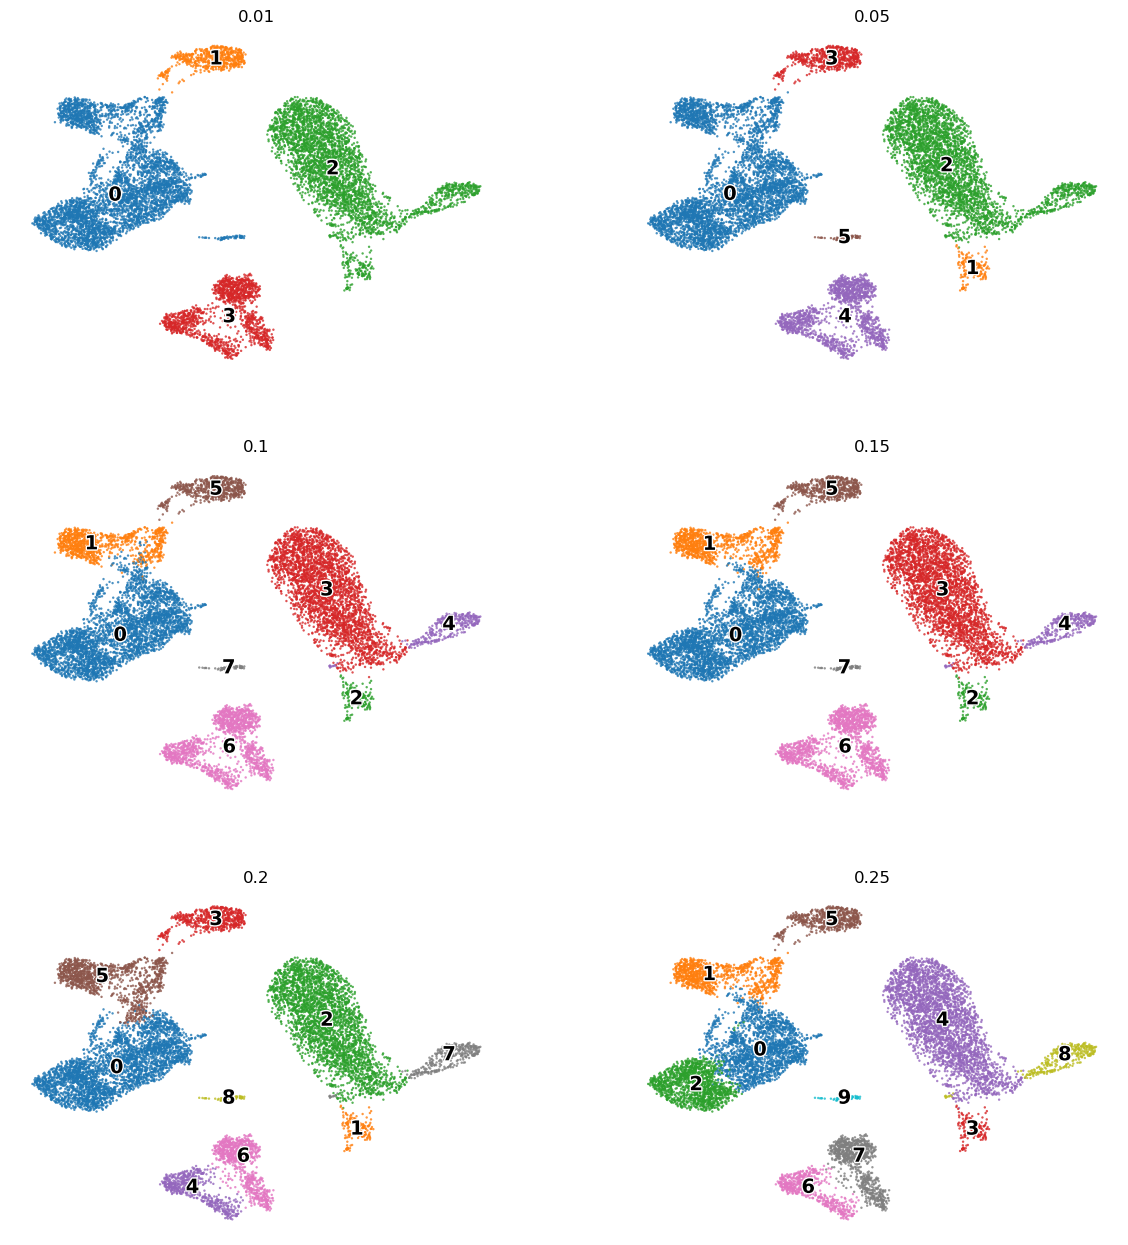

In [41]:
cluster_run_names = list(clusters.obs_key)
sc.pl.umap(adata, color= cluster_run_names, alpha=.8, s=12, legend_loc='on data', frameon=False, ncols=2, legend_fontoutline=2,legend_fontsize=14, title = l_res)


#### Clustering metics

If a clustering is good, then we expect strong cluster-specific signatures. `clustering_quality_vs_nn_summary` computes this by counting the number of genes differentially expressed between each cluster and its nearest neighboring cluster. We have reasonable defaults to define differential expression based on p-value and fold change ('naive') or based on p-value and the percent of cells detected (>= min percent incluster & <= max out-cluster -- 'strict'). See documentation of `clustering_quality_vs_nn_summary` for details including other clustering metrics computed.

In [42]:
evals = cn.tl.clustering_quality_vs_nn_summary(adata, label_cols = cluster_run_names, n_genes = 10, n_pcs_for_nn = 20)
print(evals)

                            label_col  n_clusters  n_pairs  tested_genes  \
0  autoc_pc20_pct1.00_s01_k10_res0.01           4        4         13503   
1  autoc_pc20_pct1.00_s01_k10_res0.05           6        6         13503   
2   autoc_pc20_pct1.00_s01_k10_res0.1           8        8         13503   
3  autoc_pc20_pct1.00_s01_k10_res0.15           8        8         13503   
4   autoc_pc20_pct1.00_s01_k10_res0.2           9        9         13503   
5  autoc_pc20_pct1.00_s01_k10_res0.25          10       10         13503   

   unique_naive_genes  unique_strict_genes  min_naive_per_pair  \
0                6402                 1195                   0   
1                7008                 1023                   0   
2                6886                 1048                   0   
3                6889                 1054                   0   
4                5987                  914                   0   
5                5987                  909                   0   

   m

A plot of this result is easier to digest.

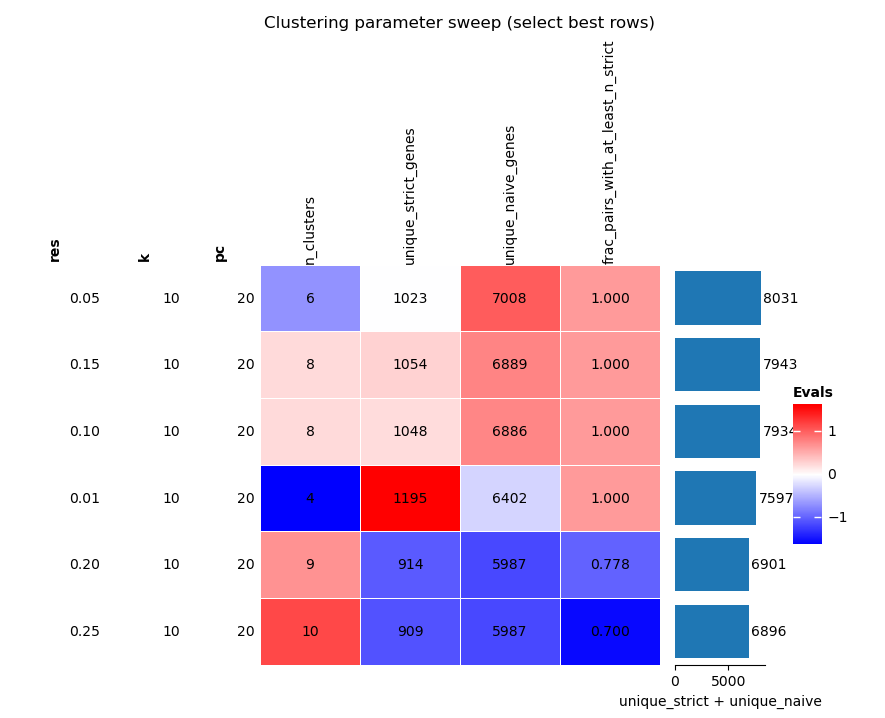

In [45]:
cn.pl.heatmap_clustering_eval(evals, cmap_eval = 'bwr')
plt.show()

The best result in terms of total number of differentially expressed genes (both naive and strict combined) is resolution = 0.10 (8 clusters). Let's compare these clustering results to previously defined 'cell_type' labels for these cells.

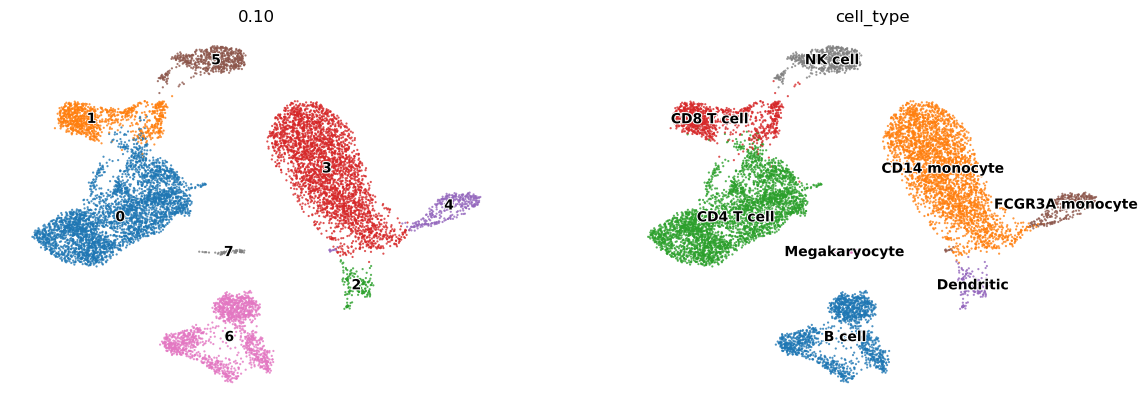

In [46]:
gby = "autoc_pc20_pct1.00_s01_k10_res0.1"
sc.pl.umap(adata, color=[gby, "cell_type"], alpha=.8, s=10, legend_loc='on data', frameon=False, ncols=3, legend_fontoutline=1.5,legend_fontsize=10, title = ["0.10", "cell_type"])


The results are highly similar. To make sure the results are sane, let's perform differential gene expression analysis and a post-hoc filtering.

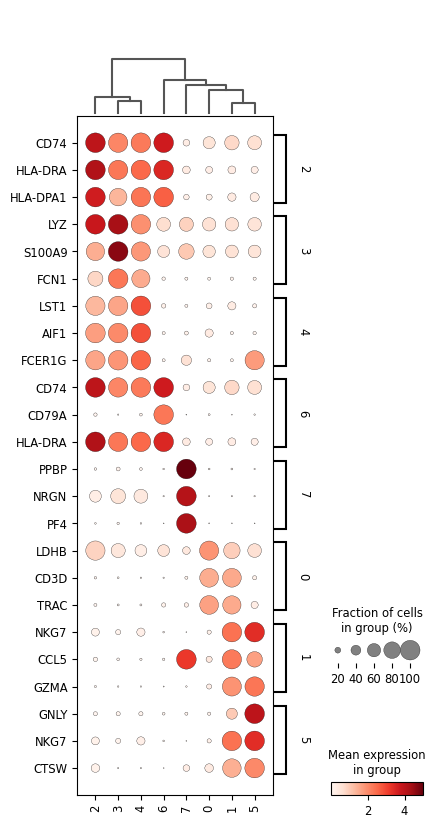

1.15.1 2.2.3


In [51]:
adata.obs[gby] = pd.Categorical(adata.obs[gby])

sc.tl.rank_genes_groups(adata, use_raw=False, groupby=gby, mask_var='highly_variable')
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3, groupby=gby, dendrogram=True, swap_axes=True)
import scipy, pandas
print(scipy.__version__, pandas.__version__)

In [48]:
minin = 0.1
maxout = 0.1
foldchange = 0.1

adata.obs[gby] = pd.Categorical(adata.obs[gby])


# adata.obs[gby] = adata.obs[gby].astype(str).astype('category')

sc.tl.filter_rank_genes_groups(adata, min_fold_change=foldchange, min_in_group_fraction=minin, max_out_group_fraction=maxout, use_raw=False)


AttributeError: 'Series' object has no attribute 'nonzero'

In [49]:
adata.obs[gby]
sc.__version__


'1.10.4'

In [ ]:

sc.pl.rank_genes_groups_dotplot(adata, n_genes=6, groupby=gby, dendrogram=True, key='rank_genes_groups_filtered', swap_axes=True)

#### Sub-clustering

Often sub-clustering a group of cells independently of other cells in the data can reveal subtler differences between groups of cells. In the PBMC data, for example, the T cell cluster (cluster 0) seems to harbor at least two different sub-groups. Let's sub-cluster cluster 0.

In [ ]:
cn.tl.cluster_subclusters(adata, cluster_column = 'autoc_pc20_pct1.00_s01_k10_res0.05', to_subcluster = ['0'], layer = 'counts', leiden_resolution=.05, n_pcs = 10)
sc.pl.umap(adata, color=['subcluster'], size=8, alpha=.8,frameon=False,legend_loc='on data')

What genes are preferentially expressed in the cluster 0 sub-groups?

In [ ]:
sc.tl.rank_genes_groups(adata, use_raw=False, groupby='subcluster', mask_var='highly_variable')

sc.tl.filter_rank_genes_groups(adata, min_fold_change=foldchange, min_in_group_fraction=minin, max_out_group_fraction=maxout, use_raw=False)

sc.pl.rank_genes_groups_dotplot(adata, n_genes=12, groupby='subcluster', dendrogram=True, key='rank_genes_groups_filtered', swap_axes=True,groups=["0_0", "0_1"])

#### 